In [27]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib.pyplot as plt


def download_and_merge(base_url: str, date: str, start_part: int, end_part: int) -> pd.DataFrame:
    df_list = []
    for part in range(start_part, end_part + 1):
        url = f"{base_url}/api/file/logs/{date}_{str(part).zfill(2)}.json"

        print(f"Fetching {url}")
        try:
            res = requests.get(url, headers={"Cookie": "auth=admin"}, timeout=10)
            res.raise_for_status()
        except Exception as e:
            print(f"Error fetching part {part}: {e}")
            continue

        if not res.text.strip():
            continue

        try:
            df_part = pd.read_json(StringIO(res.text), lines=True)
        except Exception as e:
            print(f"JSON parse error part {part}: {e}")
            continue

        df_list.append(df_part)

    if not df_list:
        raise RuntimeError("No data loaded")

    df = pd.concat(df_list, ignore_index=True)

    # Clean timestamps
    df = df.dropna(subset=["timestamp"])
    df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])

    sample = df["timestamp"].iloc[0]
    if sample > 1e18:
        unit = 'ns'
    elif sample > 1e15:
        unit = 'us'
    elif sample > 1e12:
        unit = 'ms'
    else:
        unit = 's'
    print(f"Detected timestamp unit: {unit}")

    df["datetime"] = pd.to_datetime(df["timestamp"], unit=unit, errors="coerce")
    df = df.dropna(subset=["datetime"])
    df = df.sort_values("datetime").reset_index(drop=True)

    for col in ['ADC4', 'ADC5', 'ADC6']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df["delta_s"] = df["datetime"].diff().dt.total_seconds().fillna(0)
    df = df.reset_index(drop=True)
    return df

# Example usage
base_url = "http://bubatzbeobachter.de:3201"
#base_url = "http://192.168.0.1:3201"
date = "20250714"
start_part, end_part = 1, 24

df = download_and_merge(base_url, date, start_part, end_part)
df.head()


Fetching http://bubatzbeobachter.de:3201/api/file/logs/20250714_00.json


KeyboardInterrupt: 

In [15]:
def download_and_clean(base_url: str, date: str, start_part: int, end_part: int) -> pd.DataFrame:
    df_list = []
    for part in range(start_part, end_part + 1):
        url = f"{base_url}/api/file/logs/{date}_{part}.json"
        print(f"Fetching {url}")
        try:
            res = requests.get(url, timeout=10, headers={"Cookie": "auth=admin"})
            res.raise_for_status()
        except Exception as e:
            print(f"Error fetching part {part}: {e}")
            continue

        text = res.text.strip()
        if not text:
            print(f"Part {part} is empty.")
            continue

        try:
            df_part = pd.read_json(StringIO(text), lines=True)
        except Exception as e:
            print(f"Error parsing part {part}: {e}")
            continue

        df_list.append(df_part)

    if not df_list:
        raise RuntimeError("No data loaded.")

    df = pd.concat(df_list, ignore_index=True)

    # Timestamp cleanup
    df = df.dropna(subset=["timestamp"])
    df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])

    # Detect timestamp unit
    sample = df["timestamp"].iloc[0]
    if sample > 1e18:
        unit = "ns"
    elif sample > 1e15:
        unit = "us"
    elif sample > 1e12:
        unit = "ms"
    else:
        unit = "s"
    print(f"Detected timestamp unit: {unit}")

    df["datetime"] = pd.to_datetime(df["timestamp"], unit=unit, errors="coerce")
    df = df.dropna(subset=["datetime"])
    df = df.sort_values("datetime").reset_index(drop=True)

    for col in ["ADC4", "ADC5", "ADC6"]:
        df[col] = pd.to_numeric(df.get(col), errors="coerce").astype(float)

    df["delta_s"] = df["datetime"].diff().dt.total_seconds().fillna(0)

    print("Sampling interval distribution (seconds):")
    print(df["delta_s"].value_counts().sort_index())

    return df


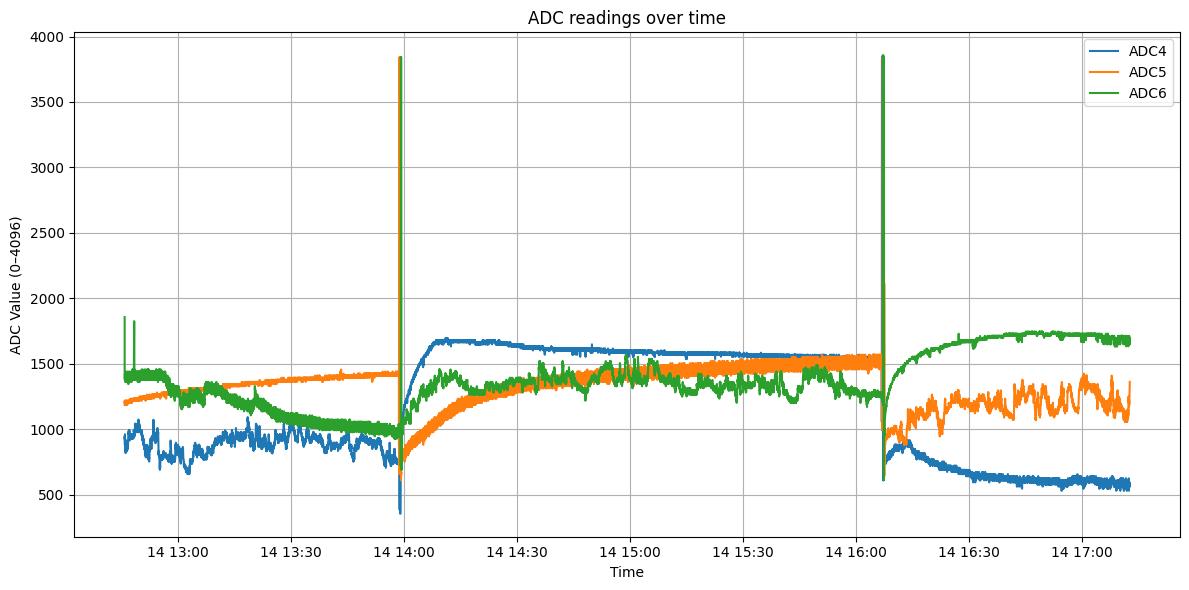

In [16]:
def plot_adc(df: pd.DataFrame, title: str = "ADC readings over time"):
    plt.figure(figsize=(12, 6))
    for col in ['ADC4', 'ADC5', 'ADC6']:
        if col in df.columns:
            plt.plot(df["datetime"], df[col], label=col)
    plt.xlabel("Time")
    plt.ylabel("ADC Value (0–4096)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_adc(df=df)

In [17]:
def map_sensors_by_time(df: pd.DataFrame) -> pd.DataFrame:
    df["P1"] = pd.NA
    df["P2"] = pd.NA
    df["P3"] = pd.NA

    # Intervals and their permutations
    intervals_left = [
        ("13:00", "13:50", ["ADC4", "ADC5", "ADC6"]),  # P1=P2=P3 as is
        ("14:30", "15:20", ["ADC5", "ADC6", "ADC4"]),  # shifted
        ("16:20", "17:20", ["ADC6", "ADC4", "ADC5"]),  # shifted
    ]
    intervals_right = [
        ("13:00", "13:50", ["ADC4", "ADC5", "ADC6"]), 
        ("14:30", "15:20", ["ADC6", "ADC4", "ADC5"]),
        ("16:20", "17:20", ["ADC5", "ADC6", "ADC4"]),
    ]
    intervals = intervals_right
    date = df['datetime'].dt.date.iloc[0]

    for start, end, order in intervals:
        start_dt = pd.to_datetime(f"{date} {start}")
        end_dt = pd.to_datetime(f"{date} {end}")
        mask = (df["datetime"] >= start_dt) & (df["datetime"] <= end_dt)

        df.loc[mask, "P1"] = df.loc[mask, order[0]]
        df.loc[mask, "P2"] = df.loc[mask, order[1]]
        df.loc[mask, "P3"] = df.loc[mask, order[2]]

    return df
df = map_sensors_by_time(df)



C:\Users\david\AppData\Local\Temp\ipykernel_16824\2857414119.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  p1 = df["P1"].replace({pd.NA: np.nan}).astype(float)
C:\Users\david\AppData\Local\Temp\ipykernel_16824\2857414119.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  p2 = df["P2"].replace({pd.NA: np.nan}).astype(float)
C:\Users\david\AppData\Local\Temp\ipykernel_16824\2857414119.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, expli

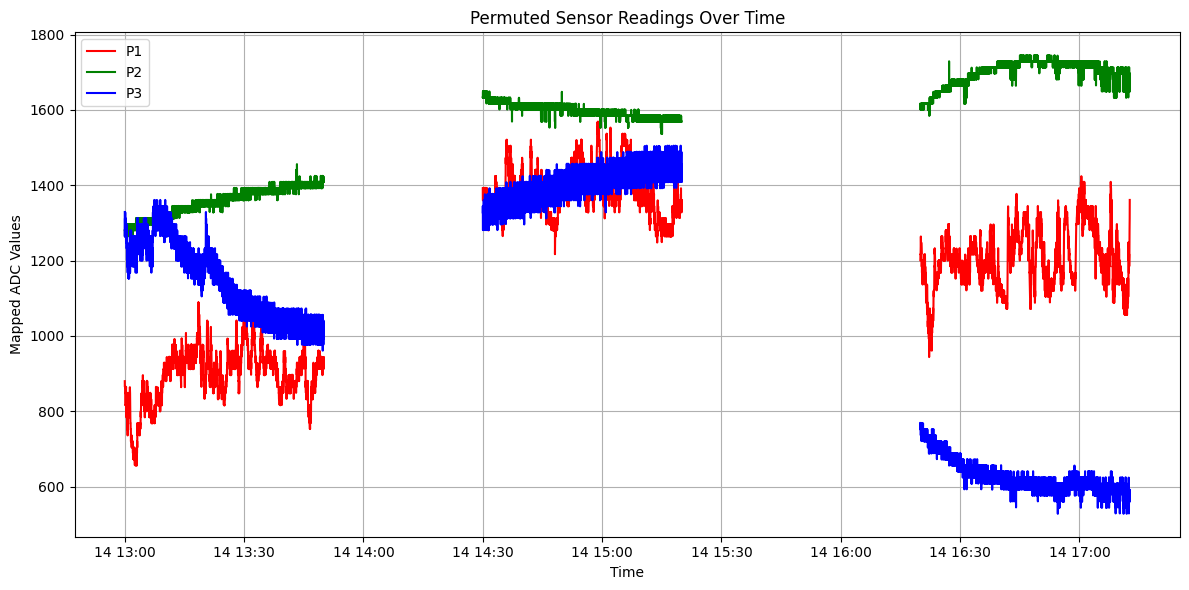

In [18]:

def plot_permuted(df: pd.DataFrame):
    plt.figure(figsize=(12, 6))

    # Replace pd.NA with np.nan first, then cast to float
    p1 = df["P1"].replace({pd.NA: np.nan}).astype(float)
    p2 = df["P2"].replace({pd.NA: np.nan}).astype(float)
    p3 = df["P3"].replace({pd.NA: np.nan}).astype(float)

    plt.plot(df["datetime"], p1, label="P1", color="r")
    plt.plot(df["datetime"], p2, label="P2", color="g")
    plt.plot(df["datetime"], p3, label="P3", color="b")

    plt.xlabel("Time")
    plt.ylabel("Mapped ADC Values")
    plt.title("Permuted Sensor Readings Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_permuted(df)


In [20]:
df.to_csv("mapped_sensors.csv", index=False)